<a href="https://colab.research.google.com/github/skumarudel/DSPS_SKumar/blob/master/Midterm/GRADED_DSPS_Skumar_mideterm2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DSPS Midterm 2021

# FBB excellent! 

this was very well done, incluing the broke power law the design of the plots, and the fit to the broke power law

# Fitting models to GRB afterglow photometry

**This midterm is based on Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf.
All photometry is from the Swift satellite and it is obtained from Table 3**

Gamma-ray bursts (GRB) are the strongest and brightest explosions in the universe. They last mere seconds but produce as much energy as the sun does in its entire 10-billion-year life. 

The Gamma Ray energy is higly beamed (collimated into jets).
We do not know how they originate, although we think they may happen during the formation of black holes and we sometimes see them in conjunction with supernovae.
After a GRB flare, the source of the burst produces an afterglow in less-energetic wavelengths.


This exam models GRBs optical afterglows with simple models with different methods. 

The GRB afterglow is generated by a powerlaw process. A line is a power law in log-log space. You are asked to fit a power law to the GRB afterglow. A broken powerlaw, or a power law whose index changes at some point, is a preferable model for the GRB afterglow which you will also fit to the data.

You are given data of brightness of a GRB seconds after explosion over time; the brightness is expressed in "magnitude" which is log(flux) - this is what astrophsyics use as a default.

**All steps labeled "661" are mandatory for the Grad students and extra credit for the undergrads**

DATA INGESTION AND PROCESSING (5 points)
- 1 Read in the input dataset (1 point)
- 2 Visualize the data (2 points)
- 3 Create the log-time variable (1 point)
- 4 Plot the data in log space(1 point)

DATA MODELING (10 points for 461; 17 points for 661)
- 5 661 choose step 5 or 6: Solve using the Normal Equation (2 points)
- 6 661  choose step 5 or 6: Fit a line with a prepackaged function (2 points)
- 7 Fit a line to the data by minimizing an objective function (3 points)
- 8 Plot all the solutions (2 points)
- 9 Create a table with the results of each method (1 point)
- 10 Now try MCMC: fit a line with MCMC using emcee (3 points).
- 11 661 Now fit the correct model which is a "broken power law" (3 points)
- 12 Plot the data with the MCMC solution(s) on top (1 point). 

EXTRA CREDIT
Model selection (3 points)

On canvas the score is up to 100 points:

- 461 are scored based on 15 points max : 15 is normalized to 100, i.e. each point is 6.7/100th. 
- 661 students are scored based on 20 points. each point is 5/100th
- extra credit give you points up to the max (15 for 461 and 20 for 661) meaning if you lost points in mandatory tasks EC can compensate for them

#Libraries needed for completing this assignments

In [ ]:
!pip install emcee
!pip install corner

# Import all the necessary packages

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import emcee
import corner
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from sklearn.linear_model import LinearRegression
from IPython.display import display, Math
%matplotlib inline


In [ ]:
## utility functions for calculating AIC and auto correlations
def AIC(N, LL, k):
  '''
  Akaike information criterion (AIC) is an estimator of prediction error
  check relative quality of statistical models for a given set of data 
  https://en.wikipedia.org/wiki/Akaike_information_criterion
  '''
  return-2/N * LL + 2 * k/N


def acorr(x):
    ax = plt.figure(figsize=(10,5)).add_subplot(111)

    x = x - x.mean()

    autocorr = np.correlate(x, x, mode='full')
    autocorr = autocorr[x.size:]
    autocorr /= autocorr.max()

    return ax.stem(autocorr)

#1 Read in the input dataset (1 point)
You can use Pandas to read the csv file found here 
https://github.com/fedhere/DSPS_FBianco/tree/master/midterm

In [ ]:
grbAG = pd.read_csv('https://raw.githubusercontent.com/fedhere/DSPS_FBianco/master/midterm/grb050525A.csv', sep=',')
grbAG['logtime'] = np.log10(grbAG['time'])

In [ ]:
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


In [ ]:
grbAG.tail()

,filter,time,mag,magerr,upperlimit,logtime
114,W1,63738,21.20,NaN,1,4.804398
115,M2,74798,21.59,NaN,1,4.873890
116,U,128928,20.05,NaN,1,5.110347
117,V,971360,22.09,NaN,1,5.987380
118,V,1171176,21.16,NaN,1,6.068622



$\color{green}{\text{good}}$

# FBB 1

# FBB 1 (log variable)

In [ ]:
filters = grbAG['filter'].unique()  # All filters in the data such as U, V, W2 ...
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']  # color cycle

In [ ]:
def plot_uvot(df, cfilter='V', time='logtime', ulims=True, ax = None, **kwargs):
  '''
  Function to plot Magnitude vs Time since trigger
  It takes dataframe as input
  Provide filter type (u, v w ..), dedfault is V
  whether to plot time in log or scale in log
  if ulims = True, it will plot ulims otherwise it will plot only points
  '''

  kwargs.setdefault('marker', 'o')
  kwargs.setdefault('markersize', 8)
  kwargs.setdefault('linestyle', '')
  kwargs.setdefault('color', 'black')
  kwargs.setdefault('alpha', 0.5)
  kwargs.setdefault('label', cfilter)

  data = df[df['filter']== cfilter]
  points = data[data['upperlimit'] == 0]
  ul = data[data['upperlimit'] == 1]
  ax = plt.gca() if ax is None else ax
  ax.set_ylim(23.5,12)
  if ulims:
    if time == 'logtime':
      ax.errorbar(points.logtime, points.mag, points.magerr, **kwargs)
      ax.errorbar(ul.logtime, ul.mag, yerr=ul.mag*0.05, lolims=True, capsize=5, zorder=10, elinewidth=1, color=kwargs['color'], linestyle='',alpha=kwargs['alpha'])
      ax.set_xlabel('Time since Trigger (Seconds)')
      ax.set_ylabel('Magnitude')
    else:
      ax.errorbar(points.time, points.mag, points.magerr, **kwargs)
      ax.errorbar(ul.time, ul.mag, yerr=ul.mag*0.05, lolims=True, capsize=5, zorder=10, elinewidth=1, color=kwargs['color'], linestyle='', alpha=kwargs['alpha'])
      ax.set_xlabel('Time since Trigger (Seconds)')
      ax.set_ylabel('Magnitude')
      ax.set_xscale('log')

  else:
    if time == 'logtime':
      ax.errorbar(points.logtime, points.mag, points.magerr, **kwargs)
      ax.set_xlabel('Time since Trigger (Seconds)')
      ax.set_ylabel('Magnitude')
    else:
      ax.errorbar(points.time, points.mag, points.magerr, **kwargs)
      ax.set_xlabel('Time since Trigger (Seconds)')
      ax.set_ylabel('Magnitude')
      ax.set_xscale('log')

  ax.yaxis.set_minor_locator(AutoMinorLocator())
  ax.tick_params(direction='in', which='both', labelsize='x-large', bottom=True, top=True, left=True, right=True)




  


# 2 Visualize the data (2 points)

Note: The data are photometric measurements: measurement of flux from an exploding star with Gamma Ray emission. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B. The information about the photometric band that collected each data point for this GRB is stored in the variable ```grbAG.filter```. 

TASK: 
- Plot the data points and the errorbars. Plot the data points with different colors for different "filters". _The filters are optical bands so they represent flux at different wavelengths. After plotting them in different colors you will treat them all the same for the purpose of this exam_.
Plot the upperlimit in a way that clearly identifies them as being different from the other points.

- **661:** Write the code that plots the data **as a function** that you will reuse it later. While this is optional for 461 students it is convenient to have the function since you will replot the data multiple times.


#3 Create the log-time variable (1 point)

Note: The emission is generated by a power-law generative process. To model it we will move to log space -log10(x)- and model it as a line there like we did in the class. _You will fit a line in log space. That corresponds to fitting a powerlaw $y=x^a$ in natural space._ 


TASK: 
- Crete a new dataframe column that contains the log10 of the time axis

- Replot the data using the same function as you did before.


#4 Plot the data in log space(1 point)
 
The brightness was given to you in log space already, but the time was not. To fit a line to a power law we need to move to log-log space, so we also need to take the log of the exogenous (_x_) variable.

TASK: 
- This time do not plot the upperlimits. Since you will not use them hereafter you can remove them from the dataset (e.g. create a view of your dataframe that does not have the upperlimits at this point)

- Plot the data with different colors for different photometric bands using the same function you used before (661: how do you write a function that allows you to choose which column of the dataframe to use for the x axis?).

(dont forget to explain what you see in the caption)

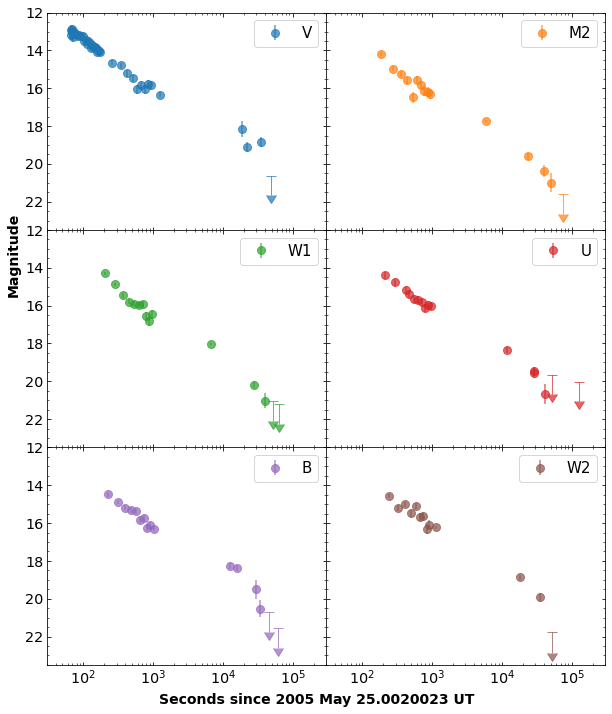

In [ ]:
filters = grbAG['filter'].unique()
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axes = plt.subplots(3,2, figsize=(10,12), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0.0)
fig.subplots_adjust(wspace=0.0)
ax = axes.flatten()
for i in range(len(filters)):
  plot_uvot(df = grbAG, cfilter=filters[i], ax = ax[i], time='time', ulims=True, color=cycle[i], alpha=0.7, label=filters[i])
  ax[i].set_xlabel('')
  ax[i].set_ylabel('')
  ax[i].set_xlim(30,3e5)
  ax[i].legend(loc='upper right',fontsize=15)

  
fig.text(0.5, 0.08, 'Seconds since 2005 May 25.0020023 UT', ha='center', fontdict={'size':14, 'weight':'bold'})
fig.text(0.07, 0.6, 'Magnitude', va='center', rotation='vertical',fontdict={'size':14, 'weight':'bold'});

**Figure 1:** Here I just tried to reproduce the image in the paper 4 in the paper. This Figure shows the photometry in the six UVOT broadband filters. It clearly shows that as the time progress, the value of magnitude increase (flux decrease) in all the bands..



$\color{green}{\text{well done}}$

# FBB 2

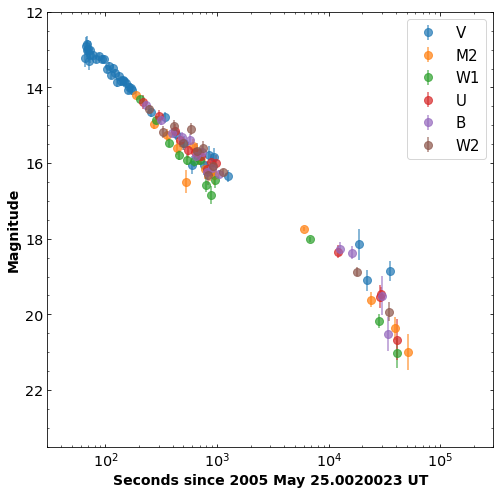

In [ ]:
filters = grbAG['filter'].unique()
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axes = plt.subplots(figsize=(8,8))
for i in range(len(filters)):
  plot_uvot(df = grbAG, cfilter=filters[i], ax = axes, time='time', ulims=False, color=cycle[i], alpha=0.7, label=filters[i])
axes.set_xlabel('Seconds since 2005 May 25.0020023 UT', fontdict={'size':14, 'weight':'bold'})
axes.set_ylabel('Magnitude',fontdict={'size':14, 'weight':'bold'})
axes.set_xlim(30,3e5)
axes.legend(loc='upper right',fontsize=15);

**Figure 2:** Here I just tried to reproduce the image in the paper 4 in the paper. This Figure shows the photometry in the six UVOT broadband filters all on one plot using different colors. It clearly shows that as the time progress, the value of magnitude increase (flux decrease) in all the bands.



$\color{green}{\text{good}}$

# FBB 2

#5 661 - choose step 5 or 6: Solve using the Normal Equation (2 points)

_From here onwards your exogenous (x) variable is lottime_

It can be shown that the best linear fit to data is given by the equation:  

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: sloper and intercept. Therefore the input has to be Nx2

TASK: 
- Fit the line function to the data (after removing the upper limits) like you did in the homework 


# Second part of assignment where I fit data above using different methods such as matrix algebra, standard package (sklearn) and using chi2 loss function

- Use the same routine as I did for HW5 to estimate parameters using matrix algebra (include the errors on data points)
- sklearn provides simple plugins to provide the same thing as matrix algebra method, just use extra parameters ``sample_weight``
- The reason for using chi2 loss function is becasue I want to use errors on the points as well when performing fitting


## defining all the functions needed to do fitting using three different methods
- If ``cfilter`` has any value like V, W, then the fitting will be done only on that particular filtered data
- However if ``cfilter`` is None, then it will combine data from all the filters and perform fitting.

In [ ]:
# Fit linear model to data using matrix algebra
def matrix_fit(data=grbAG, cfilter='V', degree=1):
  '''
  This function takes data as dataframe
  you can also select the range of data you want to use using data_range, for example by giving range(4,20), range(10,20) etc
  you can also define the degree of polynomial fit using degree parameter, where degree=1 means line fit and degree=2 mean polynomial fit of second degree
  '''
  if cfilter == None:
    df = data[data['upperlimit'] == 0]
  else:
    df = data[(data['filter']== cfilter) & (data['upperlimit'] == 0)]
  x = df['logtime'].values
  dictt = {'0': np.ones(len(x))}
  for i in range(int(degree)):
    dictt[str(i+1)] = df['logtime']**(i+1)

  A = np.column_stack(tuple(dictt.values()))
  Y = (np.array(df.mag.values)).reshape(-1,1)
  C = np.diag(df.magerr.values**2)
  X = np.dot(np.linalg.inv(np.dot(A.T, np.dot(np.linalg.inv(C), A))), np.dot(A.T, np.dot(np.linalg.inv(C), Y)))
  Covariance = np.linalg.inv(np.dot(A.T, np.dot(np.linalg.inv(C), A)))
  parameters = X.flatten()
  variances = np.diagonal(Covariance)
  return parameters, np.sqrt(variances)

# Fit linear model to data using sklearn fit. 
def sklearn_fit(data=grbAG, cfilter='V'):
  if cfilter == None:
    df = data[data['upperlimit'] == 0]
  else:
    df = data[(data['filter']== cfilter) & (data['upperlimit'] == 0)]
  lr = LinearRegression().fit(df[['logtime']], df['mag'], sample_weight=1/ df['magerr']**2)
  return lr.intercept_, lr.coef_[0]
#print("best fit parameters from the sklearn LinearRegression(): intercept {:.2f}, slope {:.2f}".format(lr.intercept_, lr.coef_[0]))

# Fit linear model to data using miniminz loss function
def line(x, intercept, slope):
  return intercept + (slope * x)
    
def loss(args, x, y, yerr, func=line):
  model = func(x,*args)
  chi2 = np.sum((y - model)**2 / yerr**2)
  return chi2

  
def loss_fit(data=grbAG, cfilter='V'):
  if cfilter == None:
    df = data[data['upperlimit'] == 0]
  else:
    df = data[(data['filter']== cfilter) & (data['upperlimit'] == 0)]
  x = df['logtime'].values
  y = df['mag'].values
  yerr = df['magerr'].values

  par = minimize(loss, x0=[2,5], args=(x,y,yerr, line), method='TNC')
  return par.x[0], par.x[1]


# 6 661 choose step 5 or 6: Fit a line with a prepackaged function (2 points)
 _From here onwards your exogenous (x) variable is logtime_
 
 TASK: 
 - Fit a line to the logdata (excluding the upper limits) with a prepackaged function. You can choose to use sklearn LinearRegression (preferred), scipy linefit, or some other prepackaged function




# 7 Fit a line to the data by minimizing an objective function (3 points)


TASK:
- First, write an objective (or loss) function and justify which function you used. 
- Then use ```scipy.optimize.minimize()``` to minimize it.




# 8 Plot all the solutions (2 points)

TASK: 
- Create a function that uses the parameters you input and plots a line. 
- Replot the data using your original function and in the same plot add a line for each solution you generated. 
- Add a legend that describes which line corresponds to which model.


### Each filter fitting and plotting


$\color{green}{\text{good! }}$



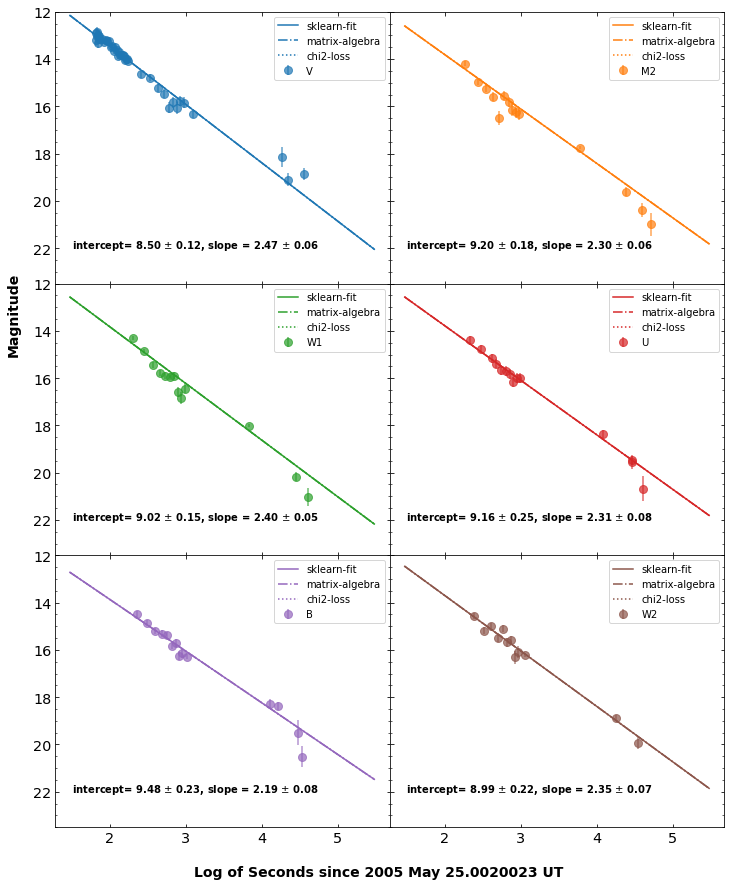

In [ ]:
fig, axes = plt.subplots(3,2, figsize=(12,15), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0.0)
fig.subplots_adjust(wspace=0.0)
ax = axes.flatten()
x = np.linspace(np.log10(30), np.log10(3e5), 100)
for i in range(len(filters)):
  plot_uvot(df = grbAG, cfilter=filters[i], ax = ax[i], time='logtime', ulims=False, color=cycle[i], alpha=0.7, label=filters[i])
  skpar = sklearn_fit(data=grbAG, cfilter=filters[i])
  matpar, matpar_err = matrix_fit(data=grbAG, cfilter=filters[i])
  minimize_par = loss_fit(data=grbAG, cfilter=filters[i])
  ax[i].plot(x, line(x,*skpar), color=cycle[i], label='sklearn-fit', linestyle='-')
  ax[i].plot(x, line(x,*matpar), color=cycle[i], label='matrix-algebra', linestyle='-.')
  ax[i].plot(x, line(x,*minimize_par), color=cycle[i], label='chi2-loss', linestyle=':')
  text = "intercept= {:.2f} $\pm$ {:.2f}, slope = {:.2f} $\pm$ {:.2f}".format(matpar[0], matpar_err[0], matpar[1],matpar_err[1])
  ax[i].text(1.5,22, s=text, fontsize=10, fontweight='bold')


  ax[i].set_xlabel('')
  ax[i].set_ylabel('')
  ax[i].legend()

fig.text(0.5, 0.08, 'Log of Seconds since 2005 May 25.0020023 UT', ha='center', fontdict={'size':14, 'weight':'bold'})
fig.text(0.07, 0.6, 'Magnitude', va='center', rotation='vertical',fontdict={'size':14, 'weight':'bold'});

**Figure 3:** Shows the power law fit of data in six different bands along with the intercept and slope value. Basically it shows that for every 10 times increase in time since trigger (100s to 1000sec), flux decreases by 2-2.5 orders of magnitude, by 100 to 300 times.

### combine all data excluding upper limits

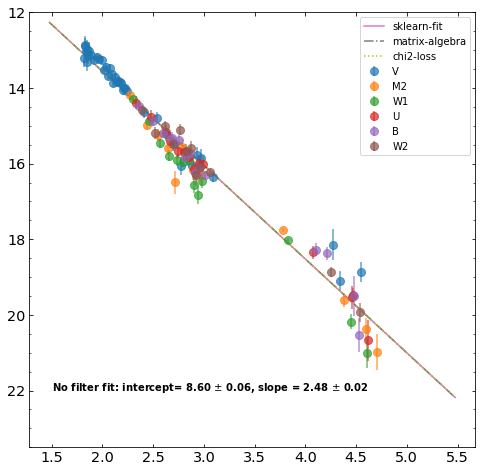

In [ ]:
fig, axes = plt.subplots(figsize=(8,8))
x = np.linspace(np.log10(30), np.log10(3e5), 100)
for i in range(len(filters)):
  plot_uvot(df = grbAG, cfilter=filters[i], ax = axes, time='logtime', ulims=False, color=cycle[i], alpha=0.7, label=filters[i])
skpar = sklearn_fit(data=grbAG, cfilter=None)
matpar, matpar_err = matrix_fit(data=grbAG, cfilter=None)
minimize_par = loss_fit(data=grbAG, cfilter=None)
axes.plot(x, line(x,*skpar), color=cycle[i+1], label='sklearn-fit', linestyle='-')
axes.plot(x, line(x,*matpar), color=cycle[i+2], label='matrix-algebra', linestyle='-.')
axes.plot(x, line(x,*minimize_par), color=cycle[i+3], label='chi2-loss', linestyle=':')
text = "No filter fit: intercept= {:.2f} $\pm$ {:.2f}, slope = {:.2f} $\pm$ {:.2f}".format(matpar[0], matpar_err[0], matpar[1],matpar_err[1])
axes.text(1.5,22, s=text, fontsize=10, fontweight='bold')


axes.set_xlabel('')
axes.set_ylabel('')
axes.legend();

**Figure 4:** Shows the power law fit of data by combining all the data points in all the filters excluding upper limits. Same conclusion as I already described in Figure 3. Basically it shows that for every 10 times increase in time since trigger (100s to 1000sec), flux decreases by 2.5 orders of magnitude, by 300 times. Also for me, the parameters estimated from three different methods are all same. See the cell below, where I printed all parameters values for three different methods


$\color{green}{\text{very nice!}}$

# FBB 3

# FBB 2

In [ ]:
skpar = sklearn_fit(data=grbAG, cfilter=None)
print("best fit parameters from the sklearn LinearRegression(): intercept {:.2f}, slope {:.2f}".format(*skpar))
matpar, matpar_err = matrix_fit(data=grbAG, cfilter=None)
print("best fit parameters from matrix albegra: intercept {:.2f}, slope {:.2f}".format(*matpar))
minimize_par = loss_fit(data=grbAG, cfilter=None)
print("best fit parameters from chi2-loss: intercept {:.2f}, slope {:.2f}".format(*minimize_par))


best fit parameters from the sklearn LinearRegression(): intercept 8.60, slope 2.48
best fit parameters from matrix albegra: intercept 8.60, slope 2.48
best fit parameters from chi2-loss: intercept 8.60, slope 2.48


# 9 Create a table with the results of each method (1 point)
(see here for table syntax in markdown) https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables


Fit Method | intercept | slope
--- | --- | ---
Sklean |8.60 | 2.48
Matrix-algebra | 8.60 | 2.48
Chi2-loss | 8.60 | 2.48



$\color{green}{\text{well done}}$

# FBB 1

# 10 Now try MCMC: fit a line with MCMC using emcee (3 points).


Assume Gaussian error which simplify the shape of the likelihood (so essentially the functions are identical to what we wrote in class this past week and you can use the code in the demo as a template https://github.com/fedhere/DSPS_FBianco/blob/master/MCMC/DIYMCMC.ipynb.)

look at documentation: https://emcee.readthedocs.io/en/stable/

TASKS:
- define a function ```log_probability```, same as we did in class


- define a function ```log_prior```, same as we did in class. Justify your choice of prior in a text cell


- define a function ```log_likelihood```, same as we did in class

- run the MCMC with the emcee package (like we did in class) and plot the marginalized distribuiton of the slope and intercept parameters in a "corner" plot like we did in class

- plot the chains


``log_priors``: I use intercept between 0 to 25, since based on data, It looks like the intercept is not going to less than 0. Similary the slope can be positive or negative (although it is posivite we know from data), I still make it between -5 to 5. Looks like a good choice. For every one order change in time, flux increase or decrease by 5 orders of magnitude at the max. So looks like a justfiable choice. 

In [ ]:
def log_prior(theta):
  intercept, slope = theta
  if 0 < intercept < 25 and -5 < slope < 5 :
    return 0
  return -np.inf

In [ ]:
def log_likelihood(theta, x, y, yerr):
  intercept, slope = theta
  # chi-squared = sum(((model - data) / error)**2)
  return -0.5*np.sum(((y - line(x, intercept, slope))**2) / yerr**2)

In [ ]:
def log_probability(theta, x, y, yerr):
  lp = log_prior(theta)
  if not np.isfinite(lp):
    return -np.inf 
  
  return lp + log_likelihood(theta, x, y, yerr)


In [ ]:
#initial guess (some suggestions are left in the code below, you can change them as you see fit)
ig = [5,2]         # can be taken from this and then modify a bit sklearn_fit(data=grbAG, cfilter=None)
#initialize walkers
nwalkers = 32
ndim = len(ig)

In [ ]:
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim)
pos.shape

(32, 2)

In [ ]:
df = grbAG[grbAG['upperlimit'] == 0]
x = df['logtime'].values
y = df['mag'].values
yerr = df['magerr'].values
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))

In [ ]:
sampler.run_mcmc(pos, 5000, progress=True)
samples = sampler.get_chain()
samples.shape

100%|██████████| 5000/5000 [00:06<00:00, 728.82it/s]


(5000, 32, 2)

In [ ]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84])
params_line = mcmc[:,1]


In [ ]:
print("best fit parameters from MCMC fitting: intercept {:.2f}, slope {:.2f}".format(*params_line))

best fit parameters from MCMC fitting: intercept 8.60, slope 2.48


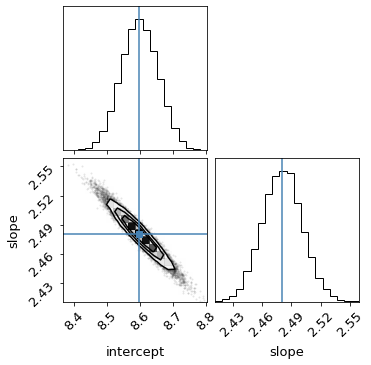

In [ ]:
labels = ["intercept", "slope"]
plt.rcParams["font.size"]= 13
fig = corner.corner(flat_samples, labels=labels, truths=mcmc[:,1]);

**Figure 5:** The corner plot shows all the one and two dimensional projections of the posterior probability distributions of intercept and slope (parameters of our model). You can also view the covariances among the parameters. For example in our case the intercept is negatively correlated with the slope. Means as intercept increase, the slope will decrease.


$\color{green}{\text{well done, good prior justification}}$

# FBB 3

In [ ]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

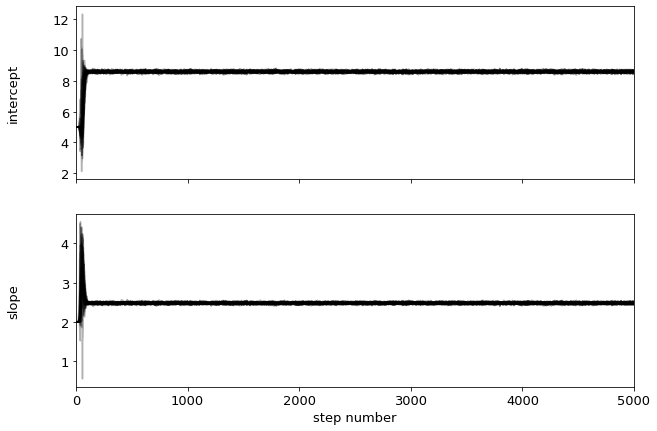

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number");

**Figure 6:** The walkers start in small distributions around the maximum likelihood values and then they quickly wander and start exploring the full posterior distribution. In fact, after fewer than 200 steps, the samples seem pretty well ``burnt-in``.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


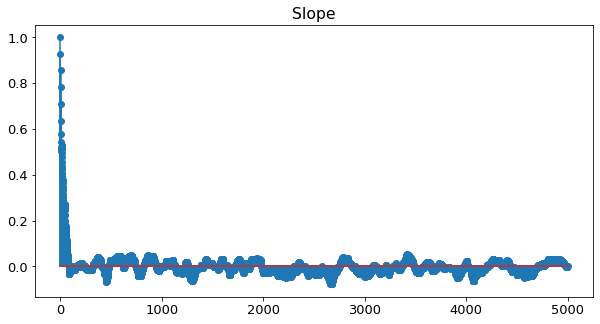

In [ ]:
acorr(sampler.chain[1,:,1])  # for slope
plt.title('Slope');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


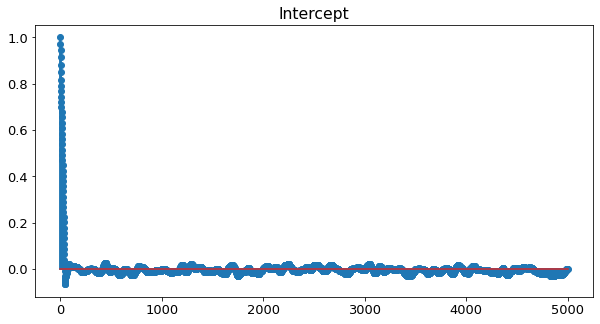

In [ ]:
acorr(sampler.chain[1,:,0])  # for slope
plt.title('Intercept');

**Figure 7:** Autocorrelation function with of chain 1 having 5000 steps. It clearly converges

In [ ]:
AIC_linefit = AIC(len(x), log_likelihood(params_line, x,y,yerr), len(params_line))
print("AIC value for line fit model is {:.2f}".format(AIC_linefit))

AIC value for line fit model is 2.98


#12 661 Fit a more correct model: a "broken power law" (3 points)

The new model in natural (not-log) space is:

$F(t) = \frac{F_0}{ \frac{t}{T_b}^{-a1} + \frac{t}{T_b}^{-a2}}$

in log space this is:

$mag(t) = b - log_{10}((\frac{t}{T_b})^{-a1} + (\frac{t}{T_b})^{-a2}) $

$a1$ is the first slope, 

$a2$ is the slope after a break

$T_b$ is the locatin of said break (in time)

$b$ is equivalent to an intercept

Note that I wrote the model as a function of t, not log(t) and the log is taken inside the function. So your _x_ variable here should be time again, not logtime. 

The parameters to be optimized then are 4: b, a1, a2, $T_b$.

TASKS: 
- Write this function up (same way in which we wrote a function for the line) 
- Write the new log_likelihood, log_prior, and log_probability. 
- Fit the new model to the data with the emcee package. Assume Gaussian error which simplify the shape of the likelihood (to essentially the same likelihood that we used in the past). 
- Make a corner plot
- Plot the chains

What would you set as a prior? Justify your choice

In [ ]:
def pl_break(x, intercept, a1, a2, Tb):
  return intercept - np.log10((x/Tb)**(-a1) + (x/Tb)**(-a2))

In [ ]:
def log_prior(theta):
  '''
  Time can not be negative, so I choose it grater than 0 and less than max value(1e5)
  slopes also looks like not more than -5 to 5 range (I tired even -10 to 10 it is same)
  intercept also kind of lies between 0 to 25. However, it can also be negative, however i was not expecting negative value based on data
  '''
  intercept, a1, a2, Tb = theta

  if -4 < intercept < 25 and -5 < a1 < 5 and -5 < a2 < 5 and 0 <Tb < 1e5 :
    return 0
  return -np.inf

def log_likelihood(theta, x, y, yerr):
  intercept, a1, a2, Tb = theta
  # chi-squared = sum(((model - data) / error)**2)
  return -0.5*np.sum(((y - pl_break(x, intercept, a1,a2,Tb))**2) / yerr**2)


def log_probability(theta, x, y, yerr):
  lp = log_prior(theta)
  if not np.isfinite(lp):
    return -np.inf 
  
  return lp + log_likelihood(theta, x, y, yerr)


In [ ]:
#initial guess (some suggestions are left in the code below, you can change them as you see fit)
ig = [15,   2,   3., 250]   # these numbers are taken from chi2 fitting using minimize method. That function is right at the end. I then change the numbers little bit
#initialize walkers
nwalkers = 32
ndim = len(ig)

pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim)
pos.shape

df = grbAG[grbAG['upperlimit'] == 0]
x = df['time'].values
y = df['mag'].values
yerr = df['magerr'].values
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))




In [ ]:
sampler.run_mcmc(pos, 10000, progress=True)
samples = sampler.get_chain()
samples.shape

100%|██████████| 10000/10000 [00:25<00:00, 389.74it/s]


(10000, 32, 4)

In [ ]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84])
params_plbreak = mcmc[:,1]


In [ ]:
params_plbreak

array([ 15.13064315,   2.13369247,   3.50280176, 292.85150535])

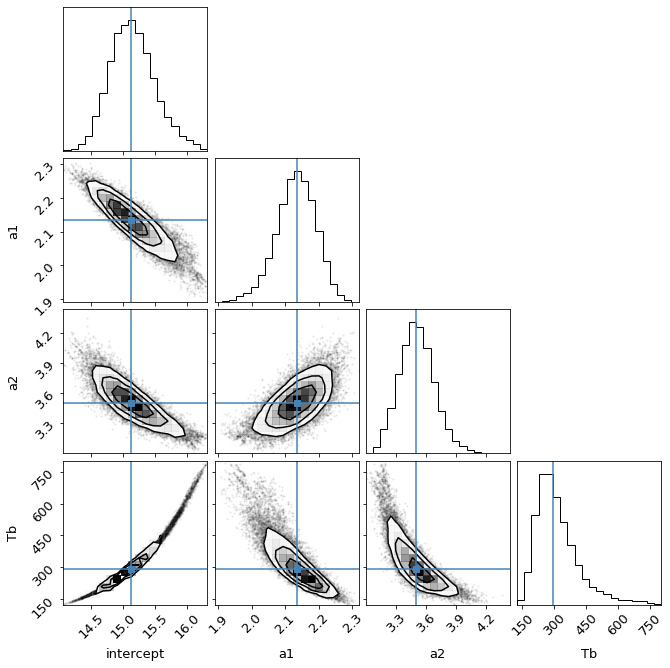

In [ ]:
labels_b = ["intercept", "a1", "a2", 'Tb']
plt.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=labels_b, truths=mcmc[:,1]);

**Figure 8:** The corner plot shows all the one and two dimensional projections of the posterior probability distributions of intercept and slope (parameters of our model). You can also view the covariances among the parameters. For example in our case the intercept is negatively correlated with the a1 and a2. Similary a1 is positively correlated with a2 Means as intercept increase, the slope will decrease.


$\color{green}{\text{good! the first one I saw done correctly so far}}$

# FBB 2

In [ ]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_b[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

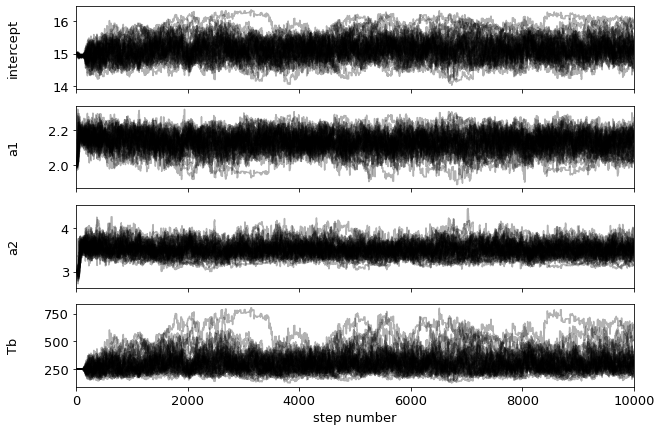

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_ylabel(labels_b[i])

axes[-1].set_xlabel("step number");

**Figure 9:** The walkers start in small distributions around the maximum likelihood values and then they quickly wander and start exploring the full posterior distribution. In fact, after fewer than 100-200 steps, the samples seem pretty well ``burnt-in``.

In [ ]:
AIC_plbreak = AIC(len(x), log_likelihood(params_plbreak, x,y,yerr), len(params_plbreak))
print("AIC value for line fit with a break model is {:.2f}".format(AIC_plbreak))

AIC value for line fit with a break model is 2.09


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


Text(0.5, 1.0, 'intercept')

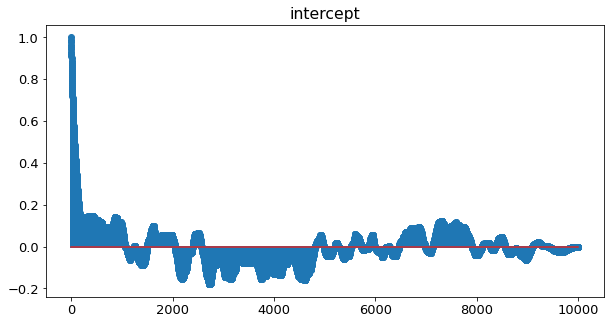

In [ ]:
acorr(sampler.chain[5,:,0])
plt.title('intercept')
#plt.show()
#print ("Fig 11: Chain Autocorrelation")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


Text(0.5, 1.0, 'a1')

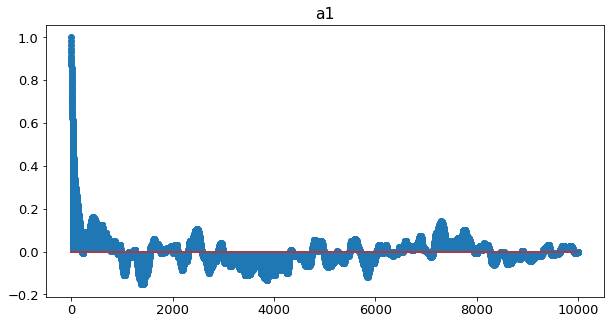

In [ ]:
acorr(sampler.chain[5,:,1])
plt.title('a1')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


Text(0.5, 1.0, 'a2')

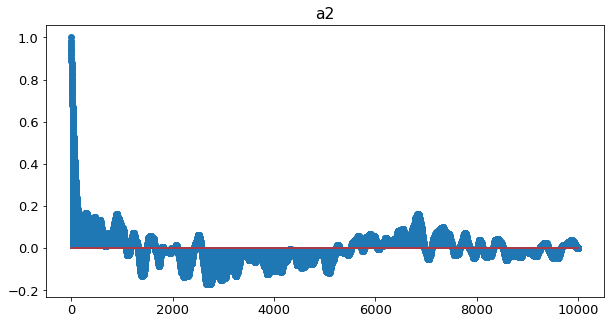

In [ ]:
acorr(sampler.chain[5,:,2])
plt.title('a2')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


Text(0.5, 1.0, 'Tb')

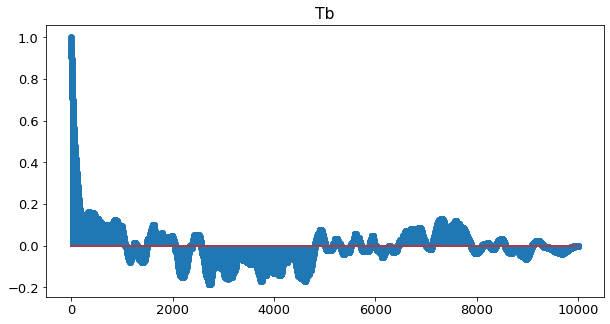

In [ ]:
acorr(sampler.chain[5,:,3])
plt.title('Tb')

**Figure 10:** Autocorrelation function with of chain 1 having 10000 steps. It clearly converges

#12 Plot the data with the MCMC solution(s) on top (1 point). 
TASK: 
- Plot the MCMC solutions, 1 i you only did point 10, 2 if you did point 11 as well. 
- If you have the broken power law solution also plot a vertical line indicating the position of the break T_b

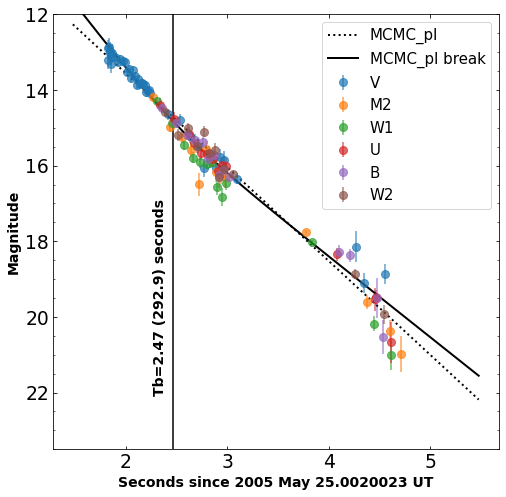

In [ ]:
xline = np.linspace(np.log10(30), np.log10(3e5), 100)
fig, axes = plt.subplots(figsize=(8,8))
for i in range(len(filters)):
  plot_uvot(df = grbAG, cfilter=filters[i], ax = axes, time='logtime', ulims=False, color=cycle[i], alpha=0.7, label=filters[i])

axes.plot(xline, line(xline,*params_line), color='black', label='MCMC_pl', linestyle=':', linewidth=2)
axes.plot(xline, pl_break(10**xline,*params_plbreak), color='black', label='MCMC_pl break', linestyle='-', linewidth=2)
axes.axvline(np.log10(params_plbreak[-1]), color='black')
axes.text(np.log10(params_plbreak[-1])-0.2, 22, s = "Tb={:.2f} ({:.1f}) seconds".format(np.log10(params_plbreak[-1]), params_plbreak[-1]), rotation='vertical',fontdict={'size':14, 'weight':'bold'})
axes.set_xlabel('Seconds since 2005 May 25.0020023 UT', fontdict={'size':14, 'weight':'bold'})
axes.set_ylabel('Magnitude',fontdict={'size':14, 'weight':'bold'})
#axes.set_xlim(30,3e5)
axes.legend(loc='upper right',fontsize=15);

#Extra Credit for everyone: Model selection

In [ ]:
AIC_linefit, AIC_plbreak

(2.976140330099301, 2.0886182946074934)

In [ ]:
probability = np.exp(-(AIC_linefit - AIC_plbreak) / 2)
print("There is a {:.2f}% probability that the line fit model better describe the data than the model yielded minimium AIC (line with break)".format(probability*100))
print("Therefore, I would like to go with a simpler model (line model, first one) based on AIC comparison")

There is a 64.16% probability that the line fit model better describe the data than the model yielded minimium AIC (line with break)
Therefore, I would like to go with a simpler model based on AIC comparison


# you may ignore after this
- I was trying to do chi2 fitting for powerlaw with break model

In [ ]:
# Fit linear model to data using miniminz loss function
def pl_break(x, intercept, a1, a2, Tb):
  return intercept - np.log10((x/Tb)**(-a1) + (x/Tb)**(-a2))
    
def loss(args, x, y, yerr, func=pl_break):
  model = func(x,*args)
  chi2 = np.sum((y - model)**2 / yerr**2)
  return chi2

  
def minimize_loss(data=grbAG, cfilter='V'):
  if cfilter == None:
    df = data[data['upperlimit'] == 0]
  else:
    df = data[(data['filter']== cfilter) & (data['upperlimit'] == 0)]
  x = df['time'].values
  y = df['mag'].values
  yerr = df['magerr'].values

  par = minimize(loss, x0=[15,2,3,275], args=(x,y,yerr, pl_break), method='TNC')
  return par


In [ ]:
minimize_loss(cfilter=None)

     fun: 217.4656353955359
     jac: array([-0.01144542,  0.40332679,  0.03739444,  0.0008697 ])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 73
     nit: 14
  status: 1
 success: True
       x: array([ 15.05267539,   2.14498399,   3.54540831, 274.845736  ])